# Notebook 04: Time Series Forecasting - Monthly

This notebook forecasts Q2, Q3, and Q4 monthly sales for watches using the data cleaned in [Notebook 1: Data Cleaning](01_data_cleaning.ipynb).

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.var import VAR

from sklearn.metrics import mean_squared_error, r2_score

import random

# custom function imports
from custom_functions import *
from forecasting_custom_functions import *

In [2]:
df_models = pd.read_csv('../data/cleaned_datasets/df_models.csv')

# Keep only items in the proposal that have previous sales
df_models.dropna(subset='proposal_priority',inplace=True)

time_now = datetime.datetime.now()
df_models.dropna(subset=time_now.strftime(f"%Y-%m"),inplace=True)

# Transform so that datetime is the index, and style_id is the colum
y = return_sales(df_models,'style_id')

# Set frequency of index
y.index = pd.PeriodIndex(y.index,freq='M') 

last_month = '2022-04'
# Reduce size of y to month with complete data
y = y.loc[:last_month,:]

# Sort values by 2022Q1 sales
y.sort_values(axis='columns',by = [last_month], ascending=False, inplace=True)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='es2811'>)

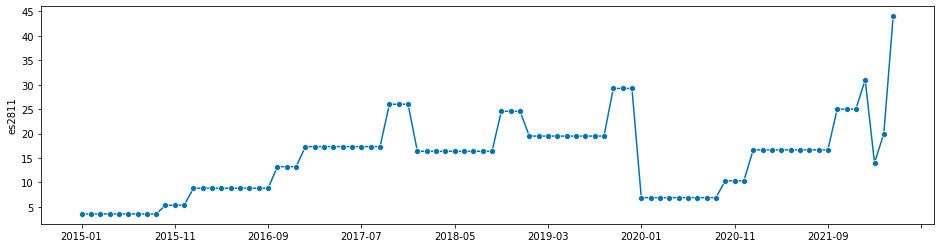

In [3]:
plot_series(y.iloc[:,0])

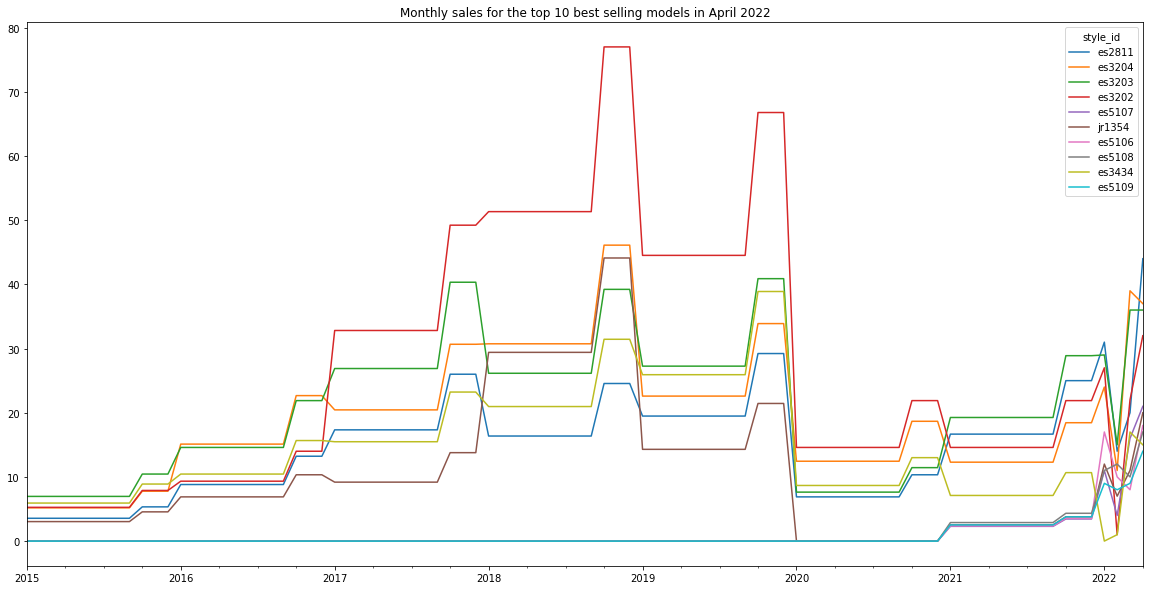

In [4]:
y.iloc[:,0:10].plot(figsize=(20,10),title='Monthly sales for the top 10 best selling models in April 2022');

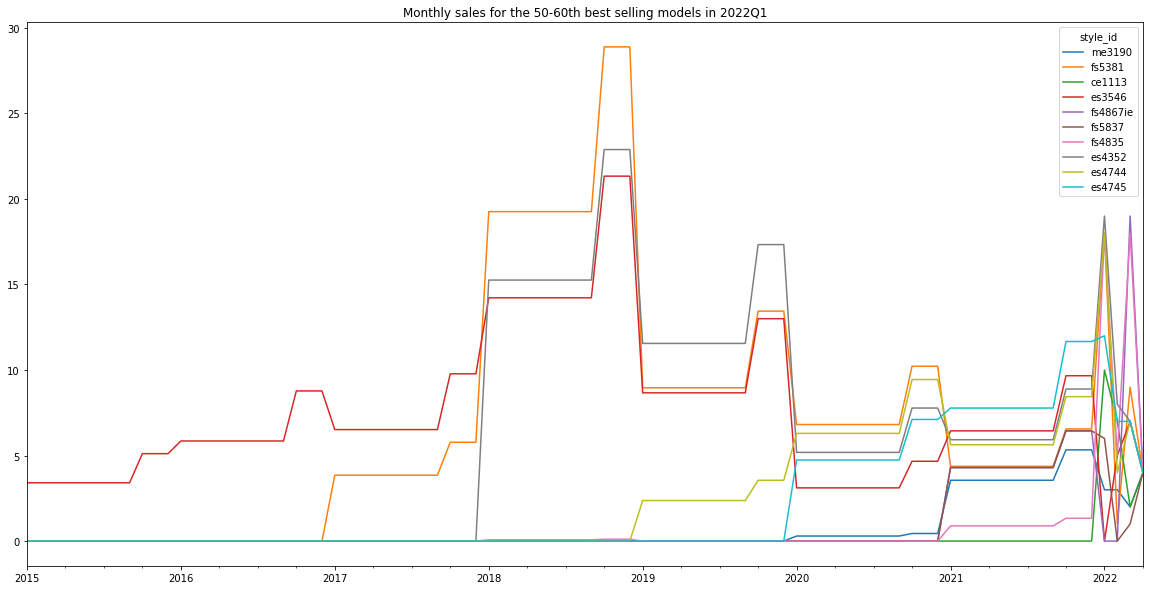

In [5]:
y.iloc[:,50:60].plot(figsize=(20,10),title='Monthly sales for the 50-60th best selling models in 2022Q1');

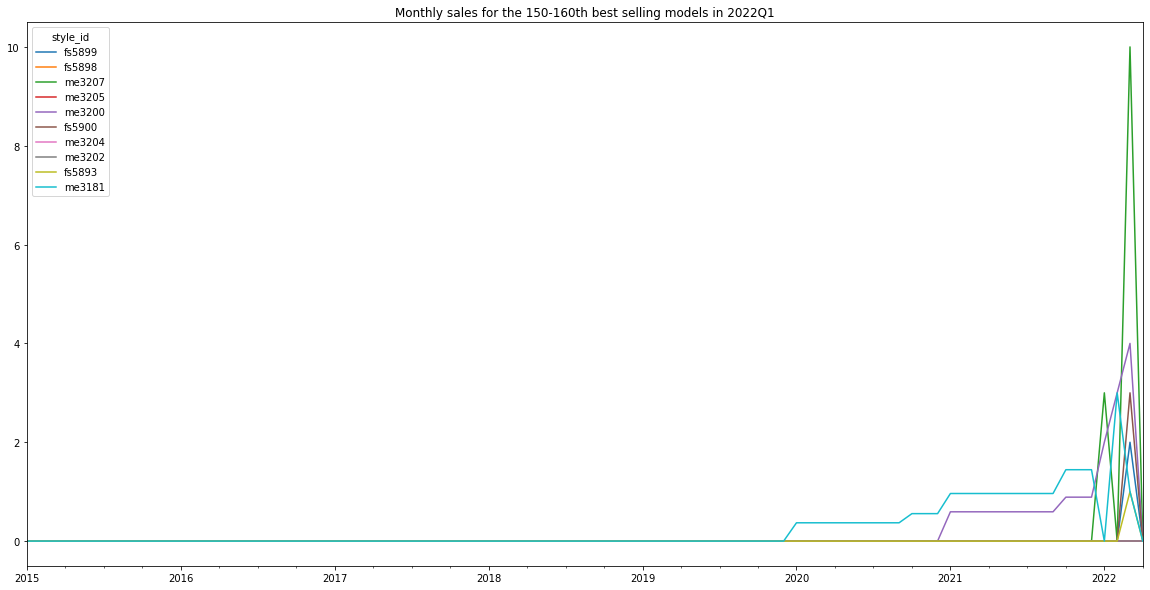

In [6]:
y.iloc[:,150:160].plot(figsize=(20,10),title='Monthly sales for the 150-160th best selling models in 2022Q1');

#### Temporal TTS

In [7]:
y_train, y_test = temporal_train_test_split(y, test_size=2)

In [8]:
y_train.shape

(86, 265)

In [9]:
y_test.shape

(2, 265)

### Baseline model using last value

In [10]:
baseline_last = NaiveForecaster() # default strategy is last

In [11]:
baseline_last.fit(y_train)

NaiveForecaster()

In [12]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 86 entries, 2015-01 to 2022-02
Freq: M
Columns: 265 entries, es2811 to me3220
dtypes: float64(265)
memory usage: 178.7 KB


In [13]:
pred_freq_list = list(range(1,10))
baseline_last_preds = baseline_last.predict(pred_freq_list)

In [14]:
baseline_last_rmse = pred_rmse(y_test, baseline_last_preds)
baseline_last_rmse

7.6530916184738516

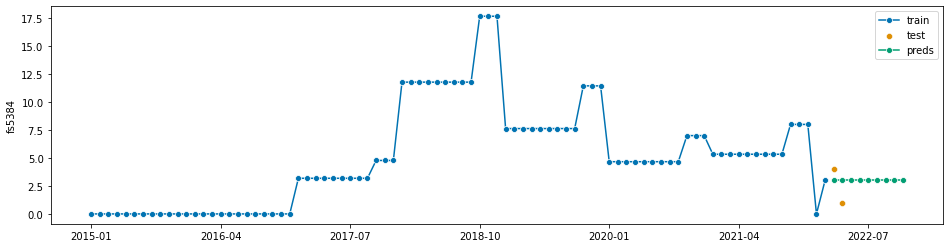

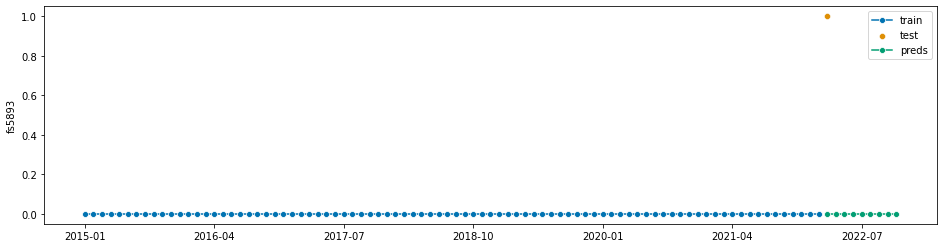

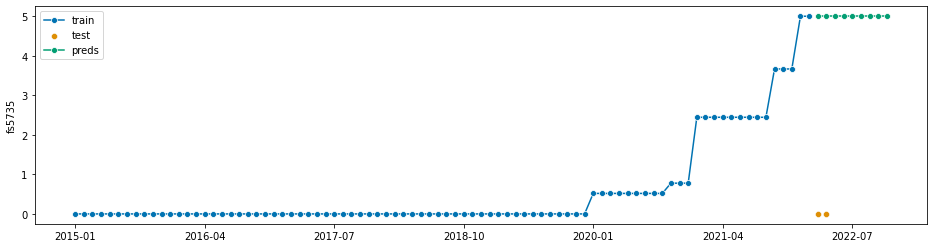

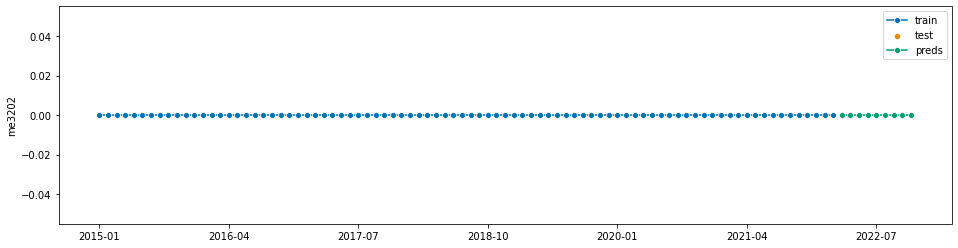

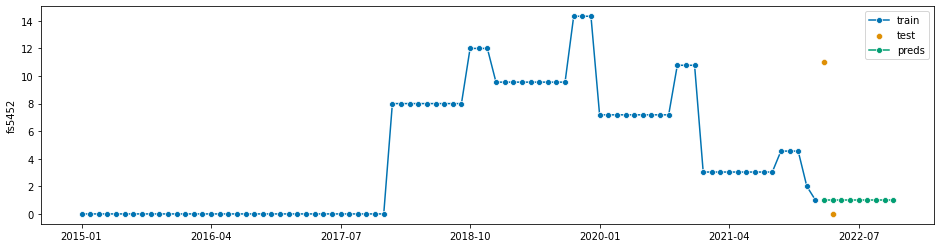

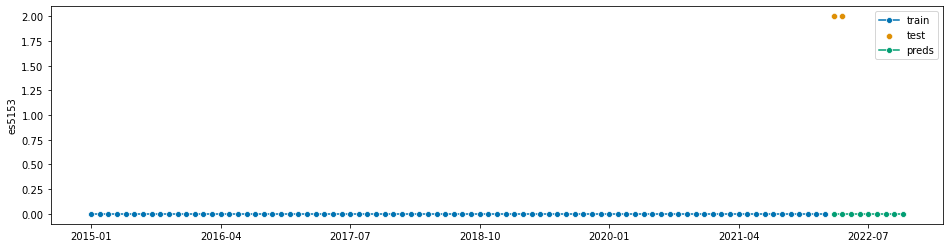

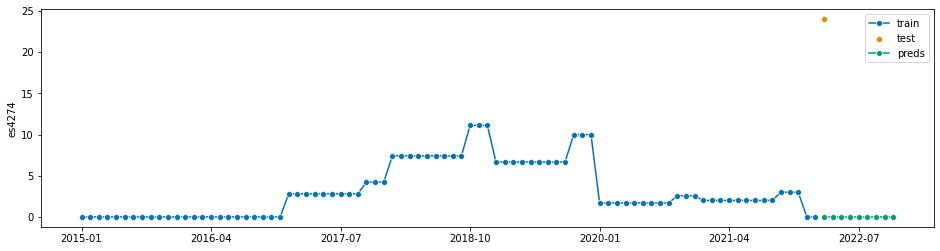

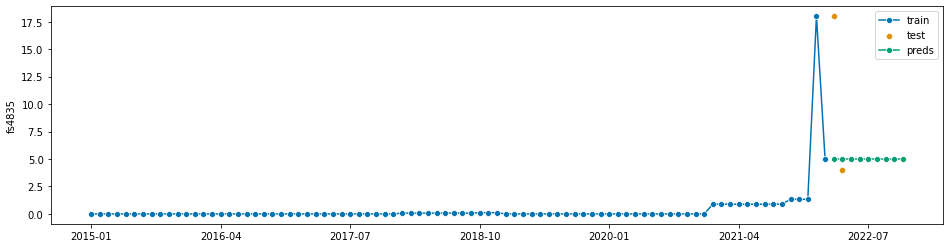

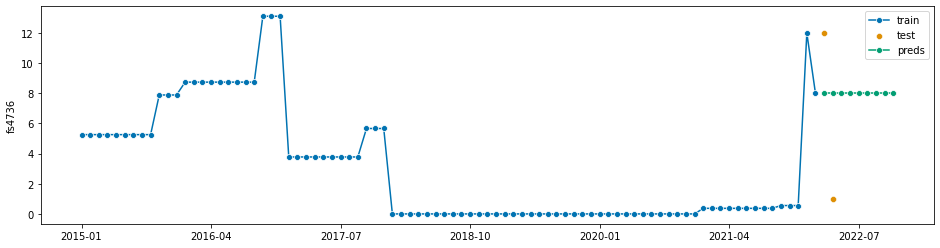

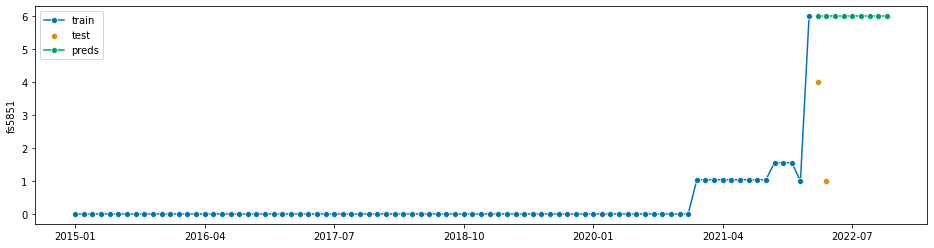

In [15]:
plot_pred(y_train, y_test, baseline_last_preds)

### Baseline model using drift

In [29]:
baseline_drift = NaiveForecaster(strategy='drift')
baseline_drift.fit(y_train)
baseline_drift_preds = baseline_drift.predict(pred_freq_list)
baseline_drift_rmse = pred_rmse(y_test,baseline_drift_preds)
baseline_drift_rmse

7.661908615053382

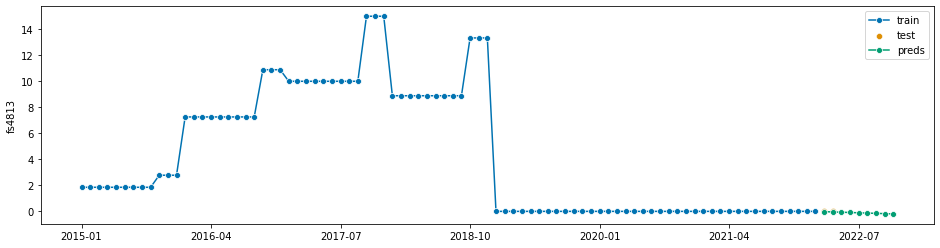

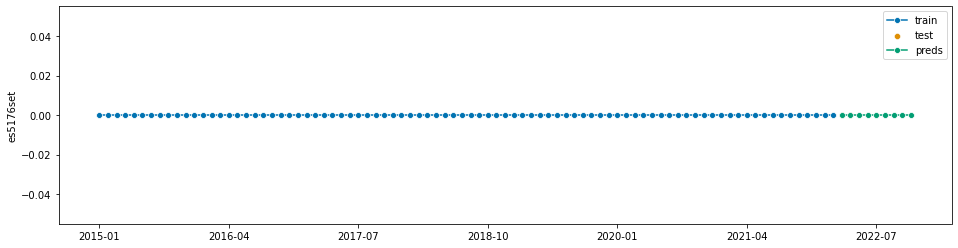

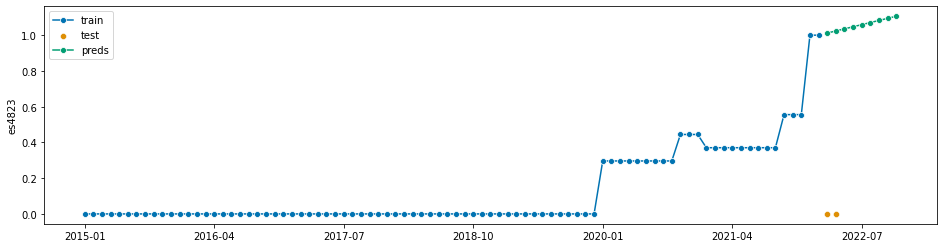

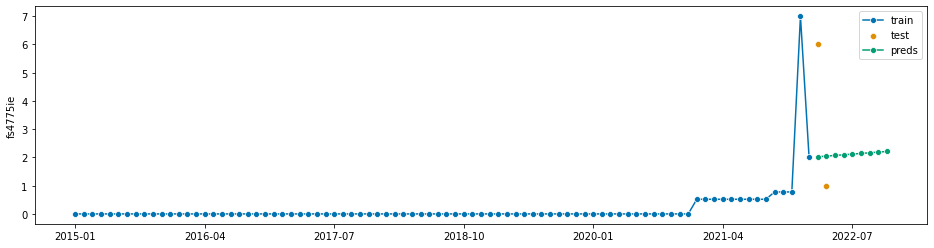

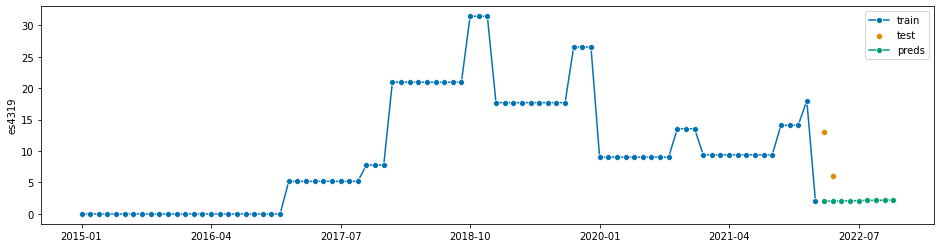

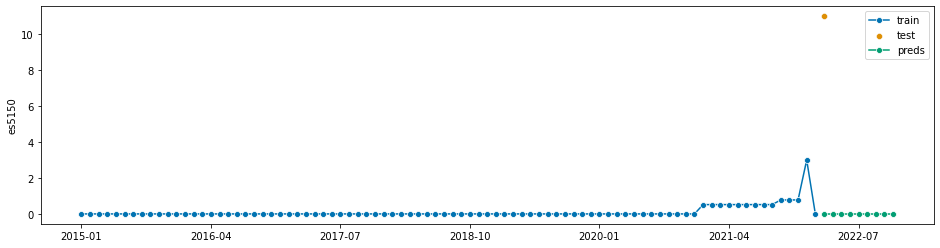

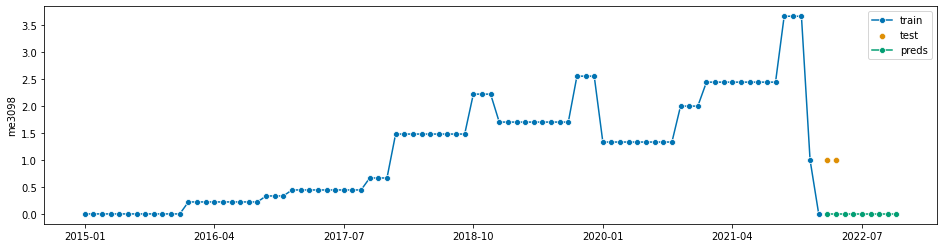

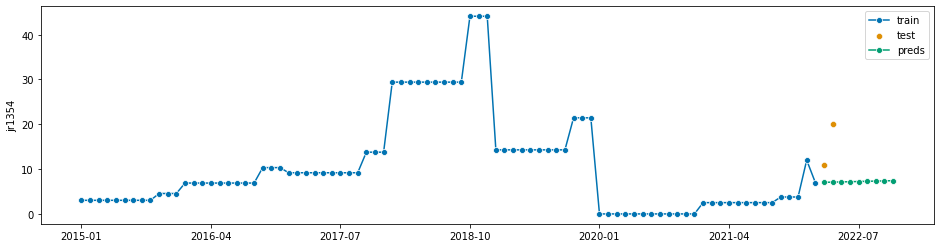

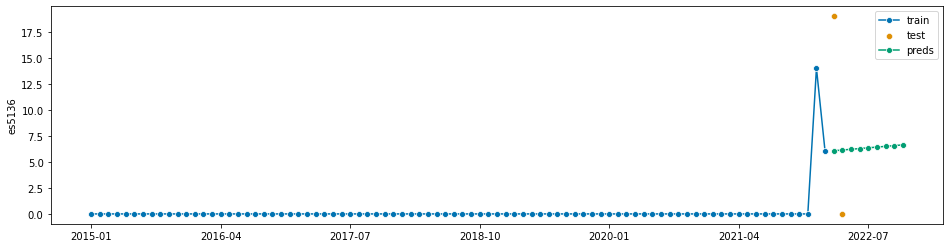

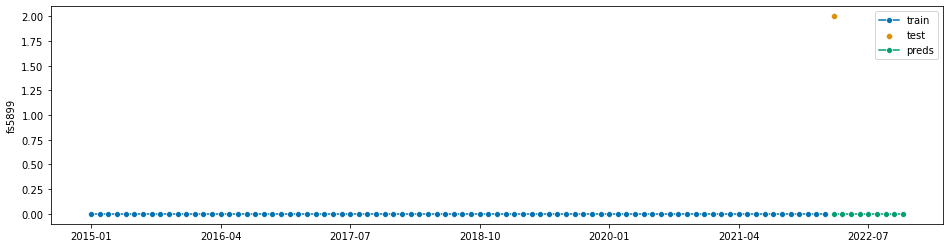

In [17]:
plot_pred(y_train,y_test,baseline_drift_preds)

### Baseline last seasonal cycle (monthly)

In [31]:
baseline_seasonal = NaiveForecaster(strategy='last',sp=12)
baseline_seasonal.fit(y_train)
baseline_seasonal_preds = baseline_seasonal.predict(pred_freq_list)
baseline_seasonal_rmse = pred_rmse(y_test, baseline_seasonal_preds)
baseline_seasonal_rmse

6.966321654518088

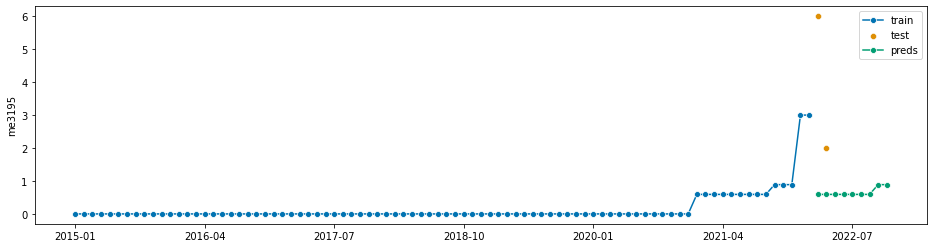

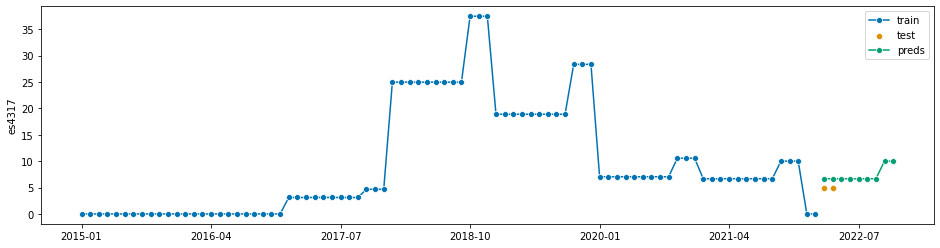

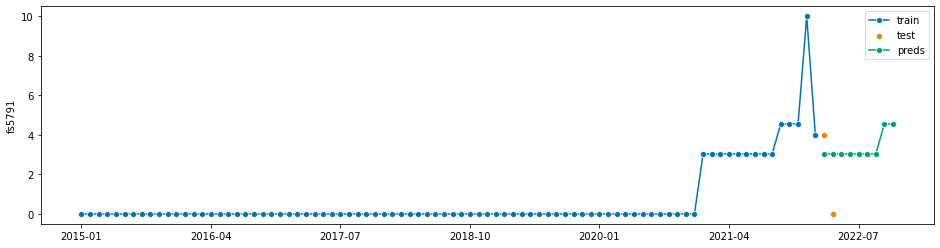

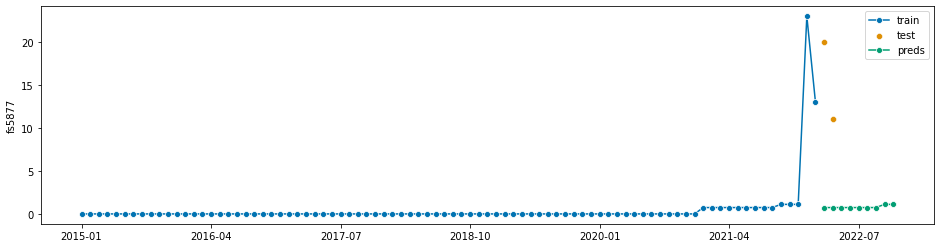

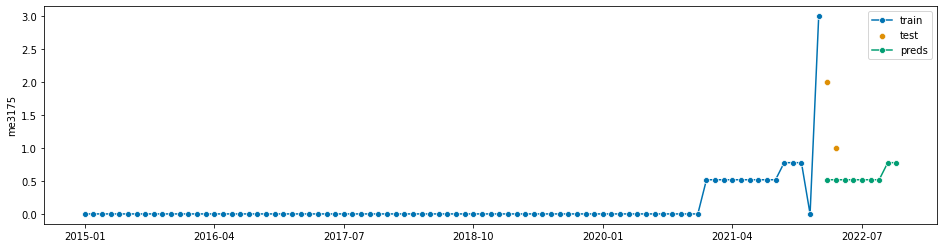

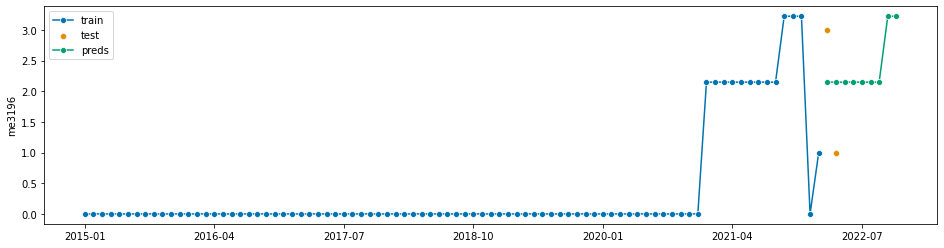

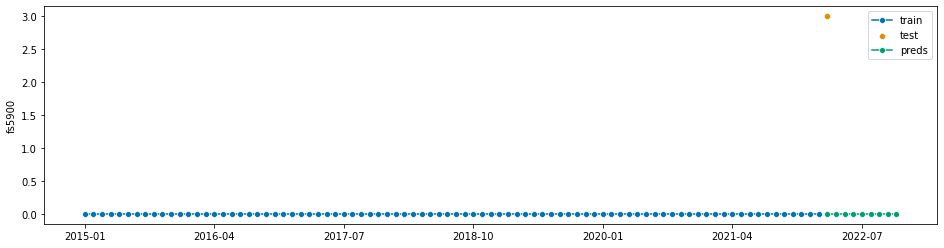

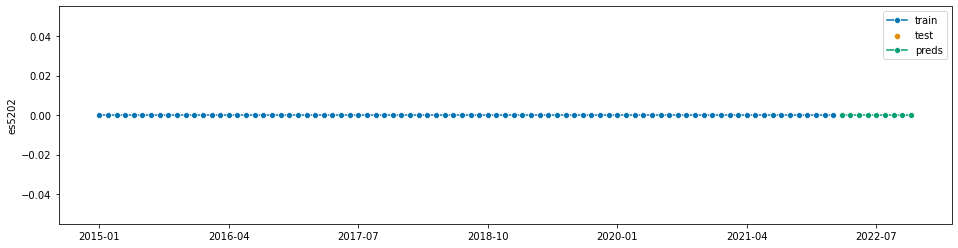

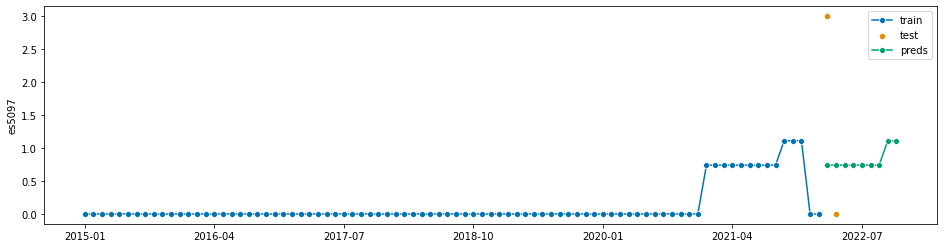

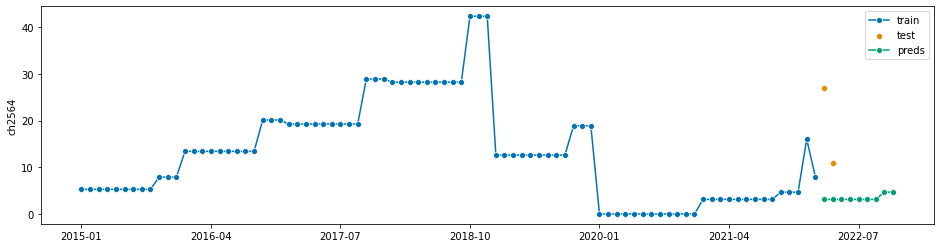

In [19]:
plot_pred(y_train, y_test, baseline_seasonal_preds)

### Baseline mean of last 6 months

In [32]:
baseline_6months = NaiveForecaster(strategy='mean',window_length=6)
baseline_6months.fit(y_train)
baseline_6months_preds = baseline_6months.predict(pred_freq_list)
baseline_6months_rmse = pred_rmse(y_test, baseline_6months_preds)
baseline_6months_rmse

6.236745415908371

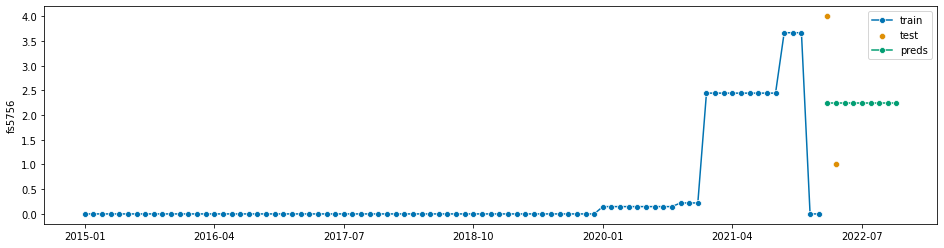

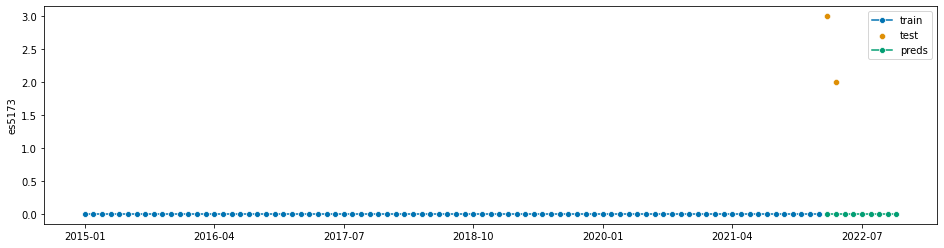

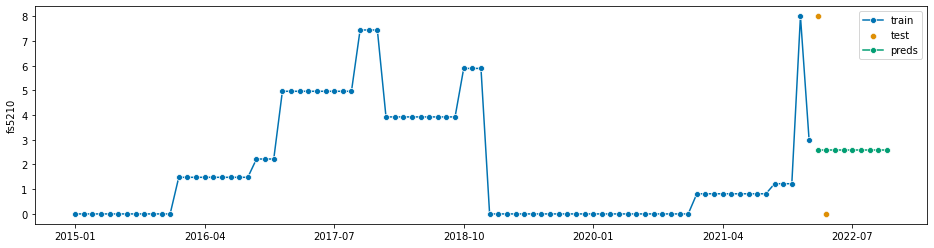

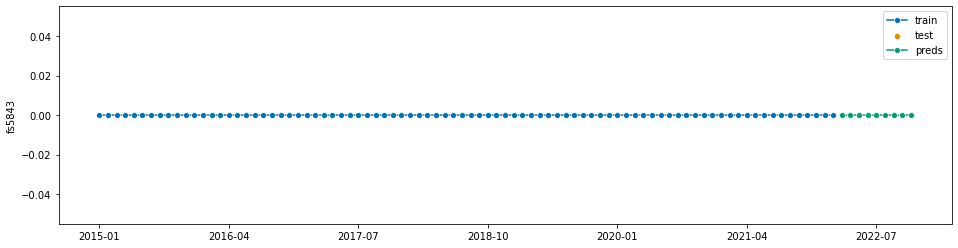

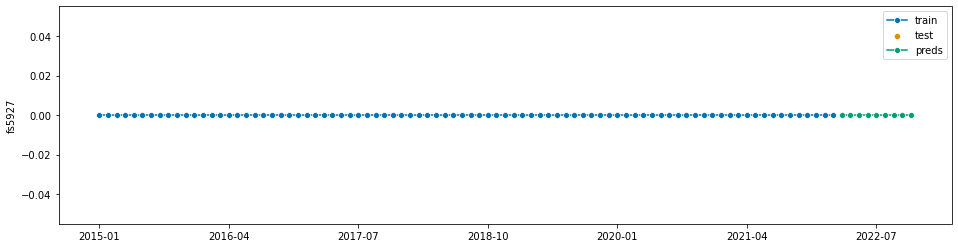

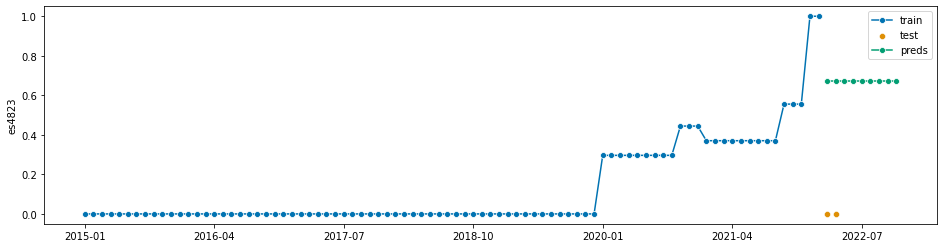

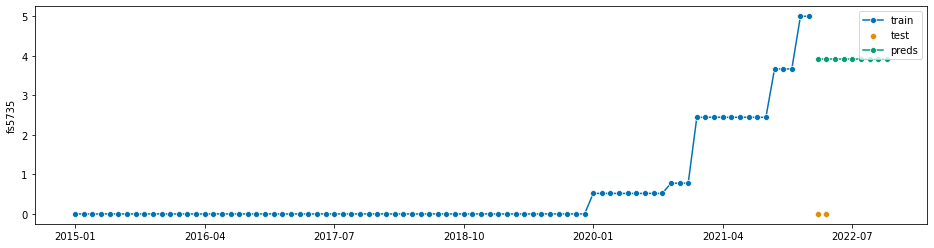

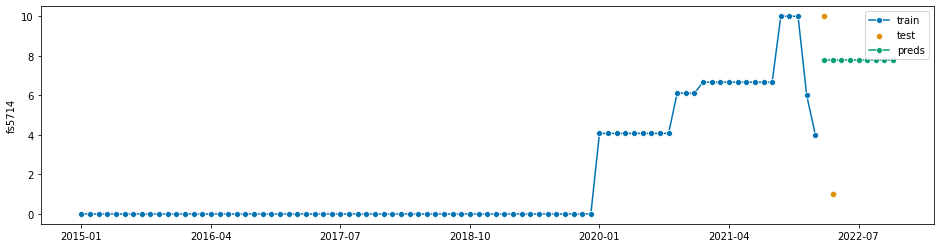

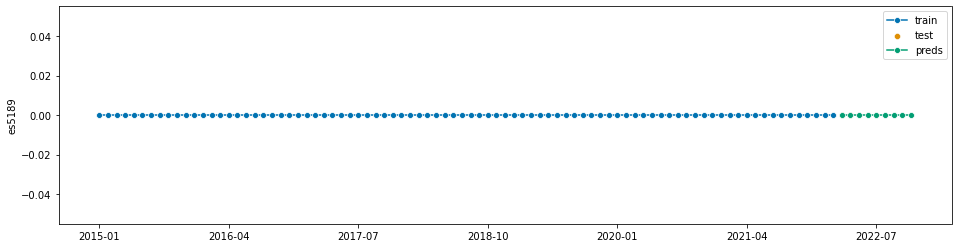

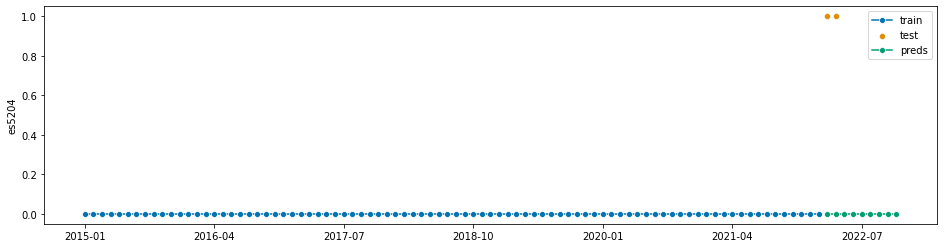

In [21]:
plot_pred(y_train, y_test, baseline_6months_preds)

### Baseline mean of last 9 months

In [33]:
baseline_9months = NaiveForecaster(strategy='mean',window_length=9)
baseline_9months.fit(y_train)
baseline_9months_preds = baseline_9months.predict(pred_freq_list)
baseline_9months_rmse = pred_rmse(y_test, baseline_9months_preds)
baseline_9months_rmse

6.441094750076926

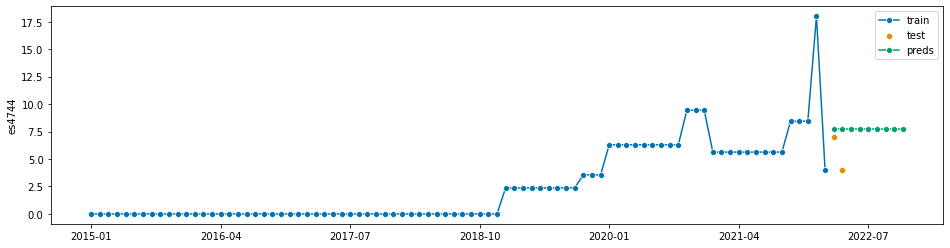

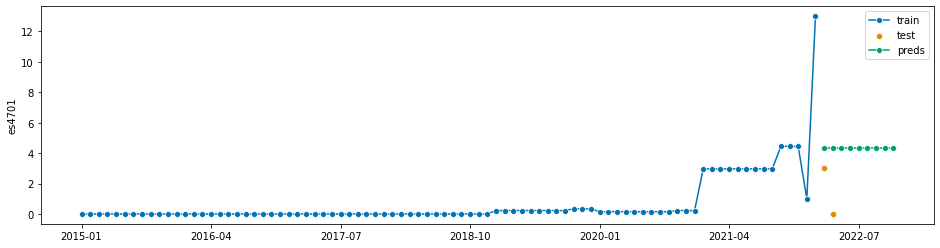

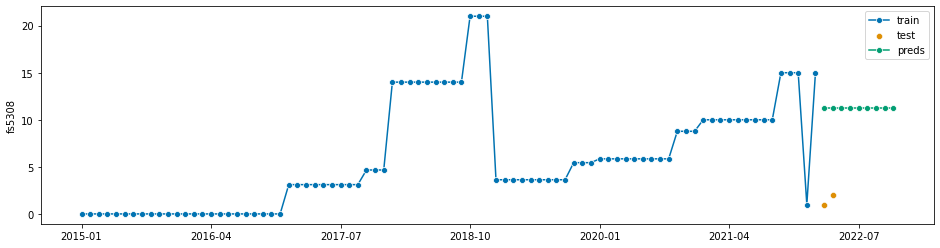

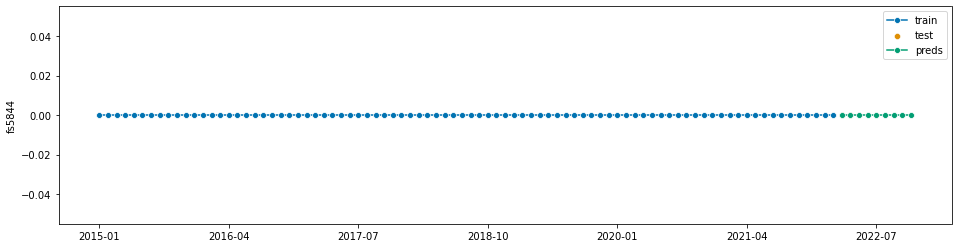

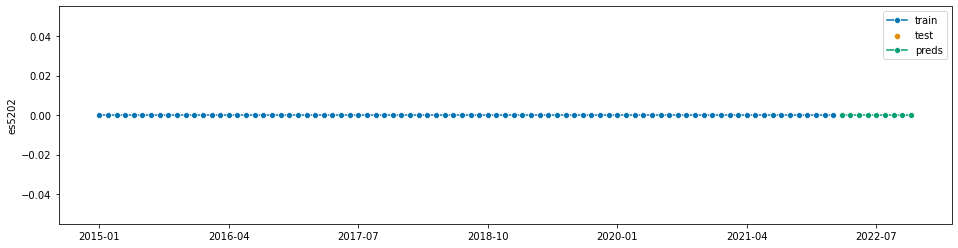

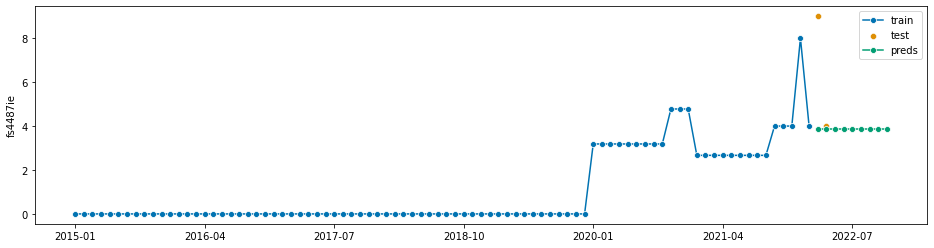

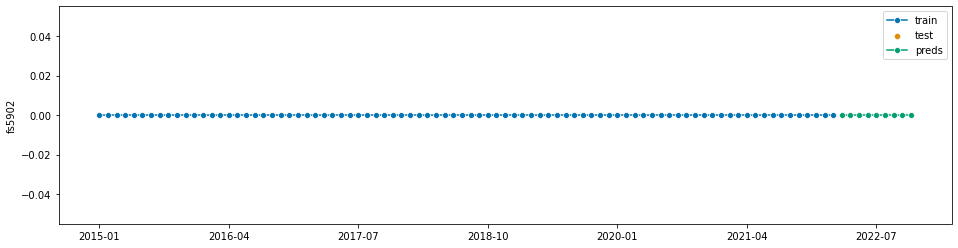

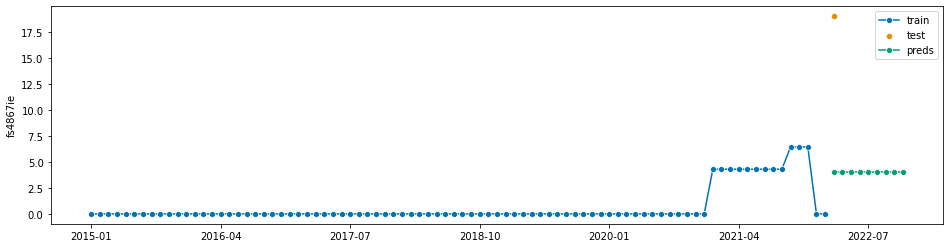

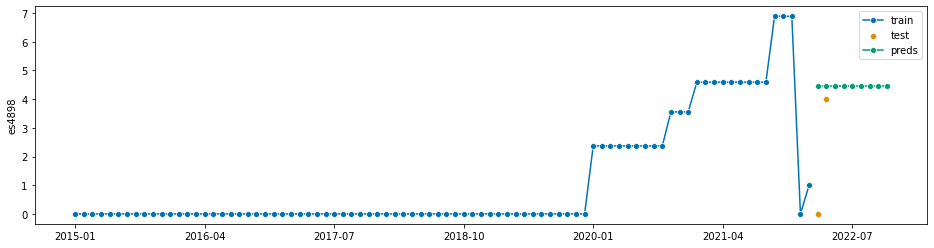

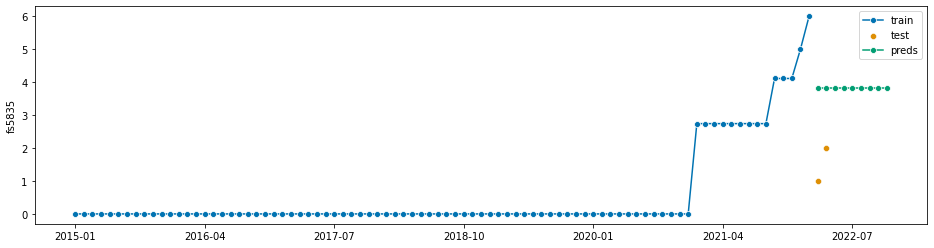

In [23]:
plot_pred(y_train, y_test, baseline_9months_preds)

### Baseline mean of last 3 months

In [34]:
baseline_3months = NaiveForecaster(strategy='mean',window_length=3)
baseline_3months.fit(y_train)
baseline_3months_preds = baseline_3months.predict(pred_freq_list)
baseline_3months_rmse = pred_rmse(y_test, baseline_3months_preds)
baseline_3months_rmse

6.196392429194501

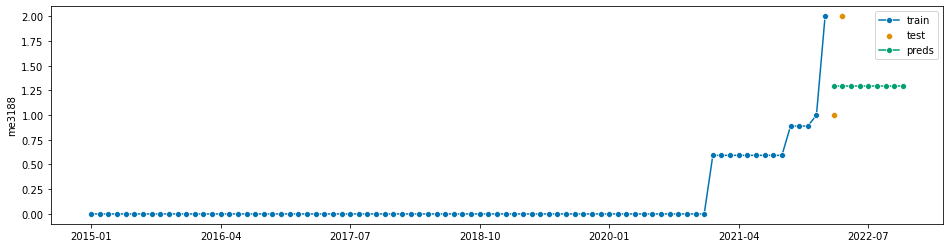

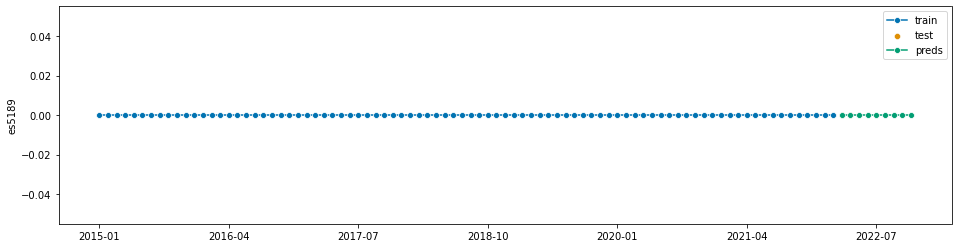

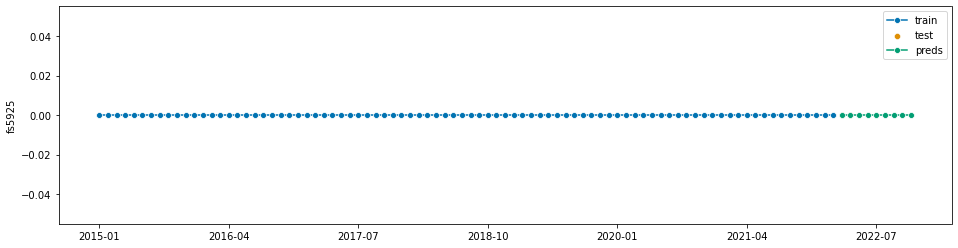

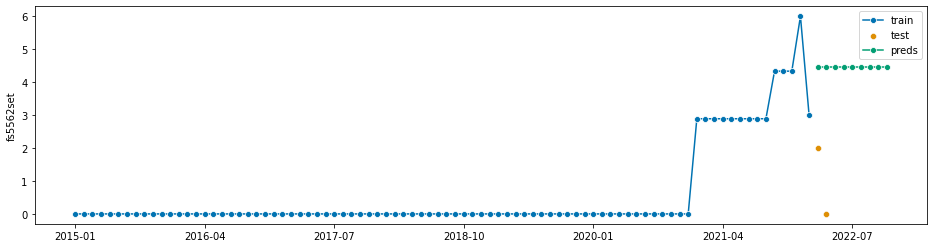

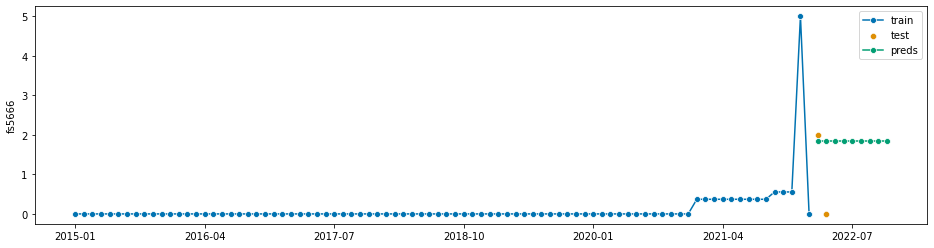

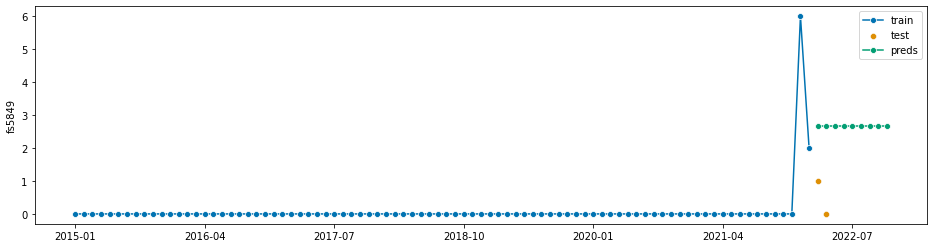

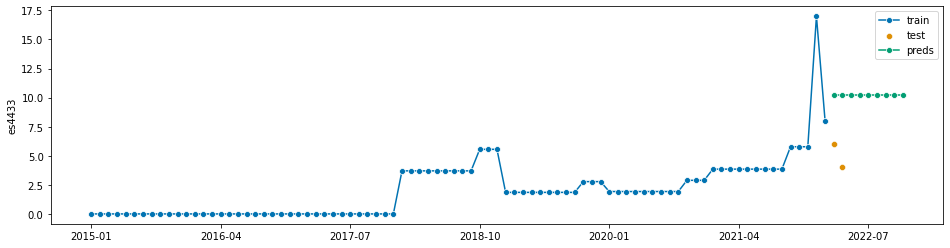

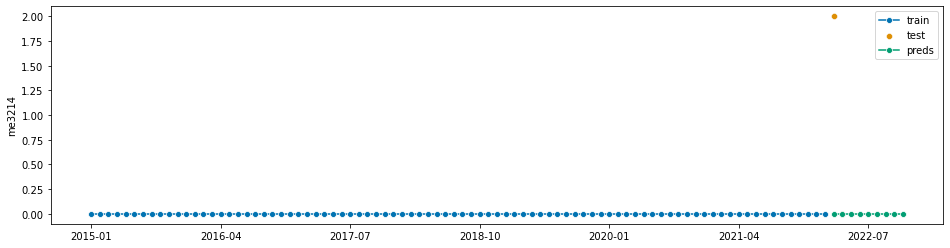

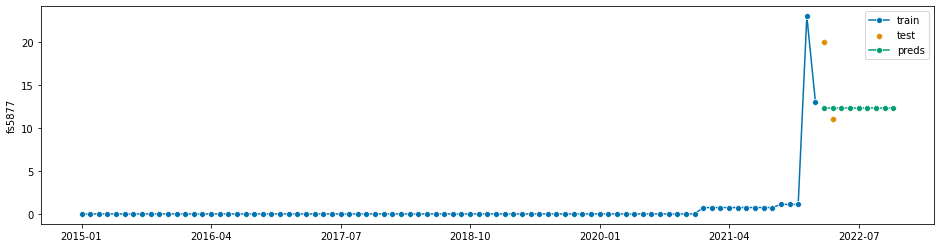

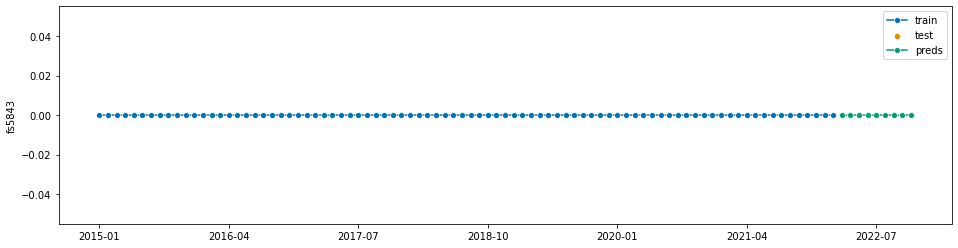

In [25]:
plot_pred(y_train, y_test, baseline_3months_preds)

### SARIMA

In [38]:
sarima_preds

,es2811,es3204,es3203,es3202,es5107,jr1354,es5106,es5108,es3434,es5109,...,fs5380,fs5437,fs5452,fs5453,fs5459,fs5512,fs5522,fs5562set,fs5661,me3220
2022-03,14.0,11.0,14.905977,1.0,10.512959,7.454703,15.485943,12.296209,1.247457,8.309495,...,10.0,3.825234e-16,1.0,2.0,2.869535,3.819049,1.968243,3.962315,-0.000005,-0.000005


In [40]:
# # Used this to generate SARIMA predictions
# sarima_preds = pd.DataFrame()
# for model in y_train:
#     sarima_model = AutoARIMA(sp=12, trace=True)
#     print(model)
#     try:
#         sarima_model.fit(y_train[model])
#         sarima_preds[model] = sarima_model.predict(1)
#     except:
#         sarima_preds[model] = np.nan
#sarima_preds.T.to_csv('../data/predictions/sarima_preds_monthly.csv')     

In [35]:
#sarima_preds = pd.read_csv('../data/predictions/sarima_preds_monthly.csv',index_col = 'Unnamed: 0')

In [41]:
sarima_preds.index = pd.PeriodIndex(sarima_preds.index,freq='M') 

In [42]:
sarima_preds

,es2811,es3204,es3203,es3202,es5107,jr1354,es5106,es5108,es3434,es5109,...,fs5380,fs5437,fs5452,fs5453,fs5459,fs5512,fs5522,fs5562set,fs5661,me3220
2022-03,14.0,11.0,14.905977,1.0,10.512959,7.454703,15.485943,12.296209,1.247457,8.309495,...,10.0,3.825234e-16,1.0,2.0,2.869535,3.819049,1.968243,3.962315,-0.000005,-0.000005


In [43]:
sarima_preds.T.isna().sum() # Only failed on 13, not too bad either

2022-03    13
Freq: M, dtype: int64

In [44]:
# Find those models which failed
model_failure_SARIMA = []
for model,failed in sarima_preds.isna().items():
    if failed[0]:
        model_failure_SARIMA.append(model)
model_failure_SARIMA

['me3208',
 'fs5862',
 'me3206',
 'ce1113',
 'fs5861',
 'me3197',
 'ce1112',
 'me3210',
 'me3207',
 'fs5850',
 'es5136',
 'fs5846',
 'fs5849']

In [45]:
sarima_preds

,es2811,es3204,es3203,es3202,es5107,jr1354,es5106,es5108,es3434,es5109,...,fs5380,fs5437,fs5452,fs5453,fs5459,fs5512,fs5522,fs5562set,fs5661,me3220
2022-03,14.0,11.0,14.905977,1.0,10.512959,7.454703,15.485943,12.296209,1.247457,8.309495,...,10.0,3.825234e-16,1.0,2.0,2.869535,3.819049,1.968243,3.962315,-0.000005,-0.000005


In [46]:
# For predictions which were negative, replace with 0.
for i in range(sarima_preds.shape[1]):
    if sarima_preds.iloc[0,i] < 0:
        sarima_preds.iloc[0,i] = 0

In [47]:
sarima_preds

,es2811,es3204,es3203,es3202,es5107,jr1354,es5106,es5108,es3434,es5109,...,fs5380,fs5437,fs5452,fs5453,fs5459,fs5512,fs5522,fs5562set,fs5661,me3220
2022-03,14.0,11.0,14.905977,1.0,10.512959,7.454703,15.485943,12.296209,1.247457,8.309495,...,10.0,3.825234e-16,1.0,2.0,2.869535,3.819049,1.968243,3.962315,0.0,0.0


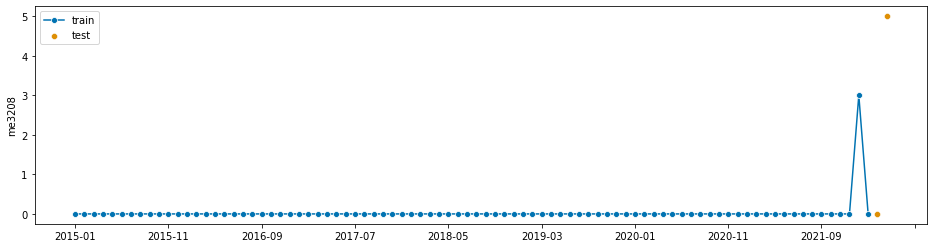

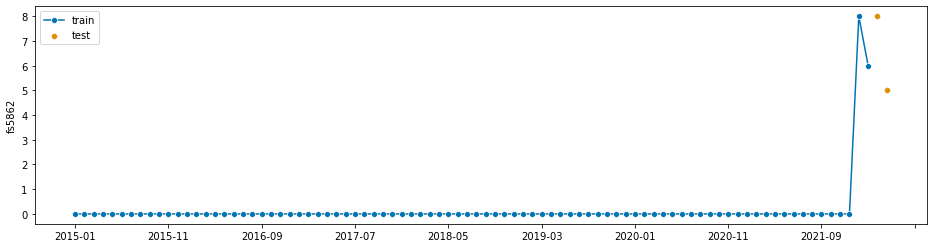

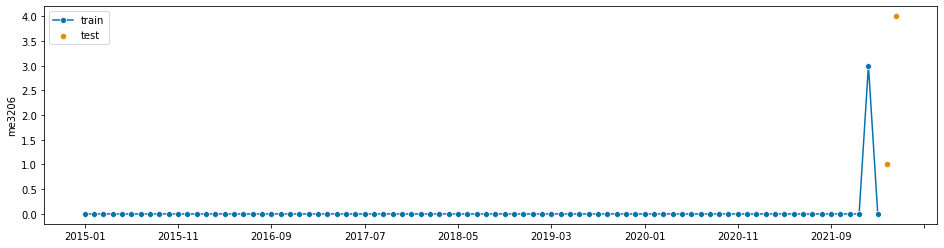

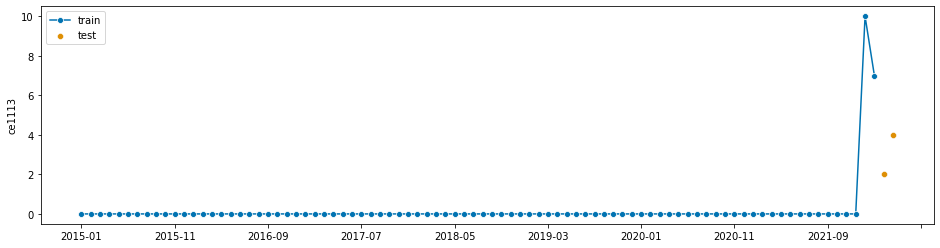

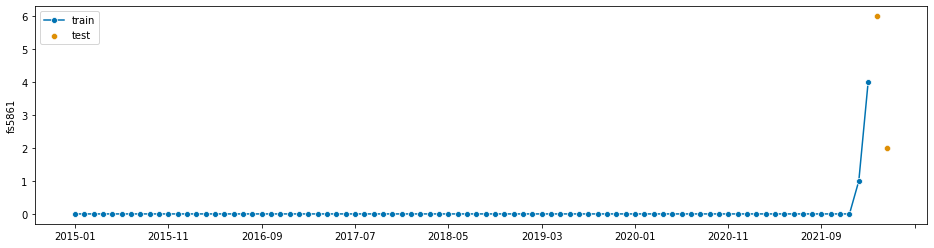

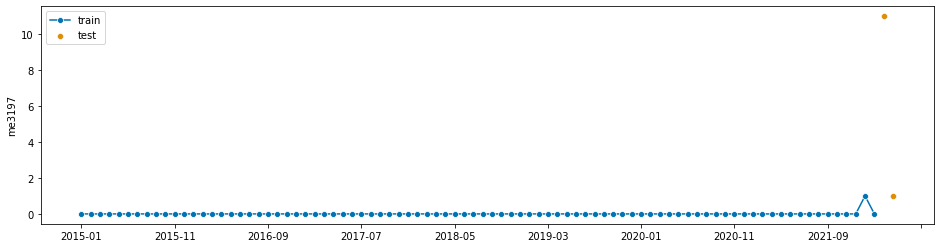

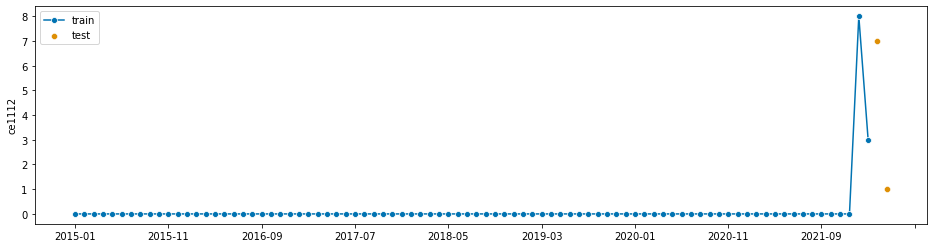

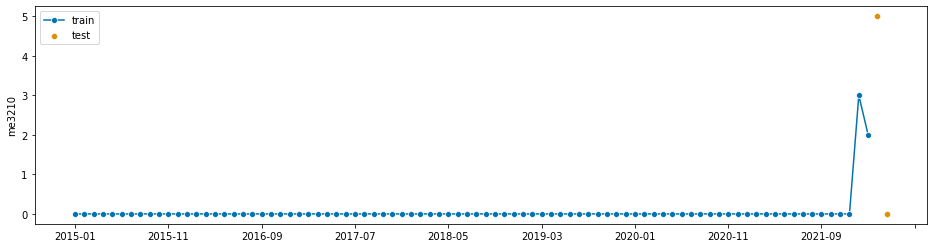

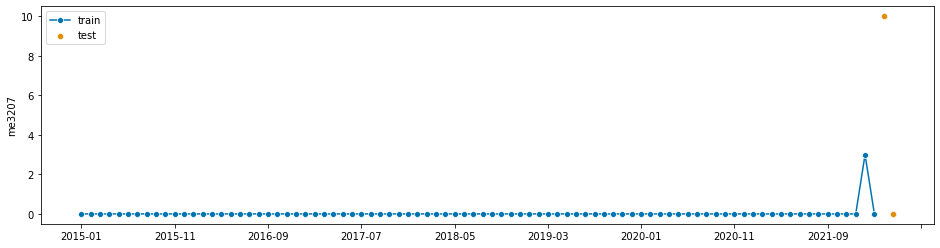

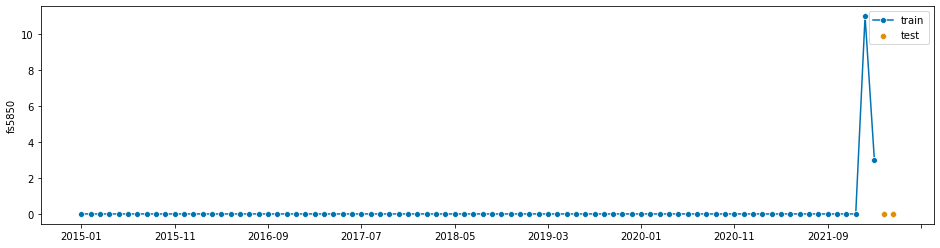

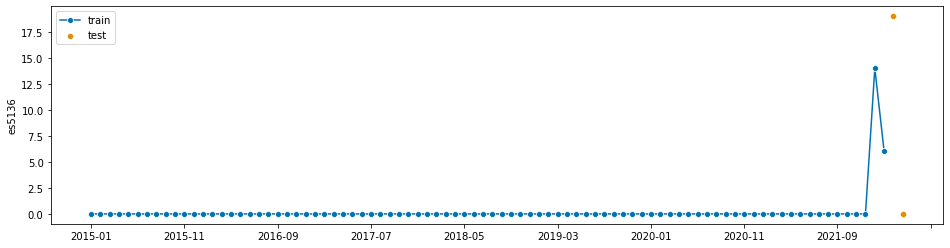

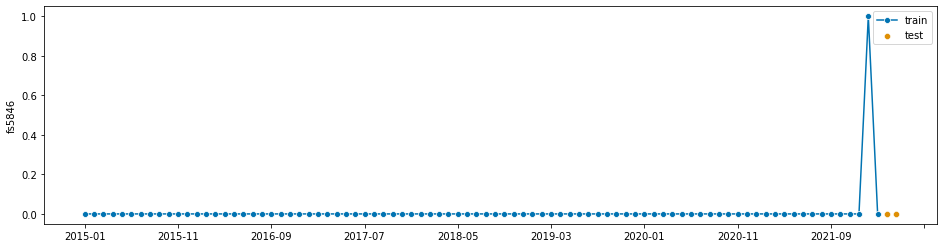

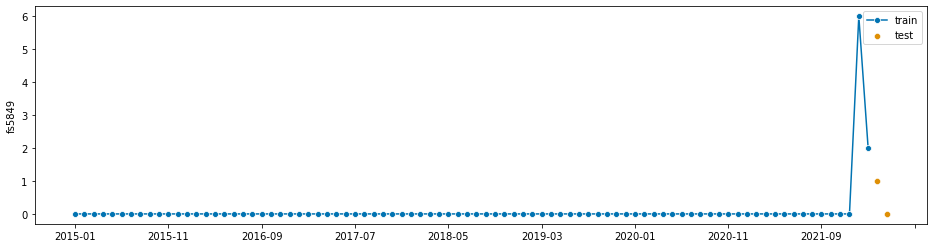

In [48]:
for i in model_failure_SARIMA:
    plot_series(y_train.loc[:,i], y_test.loc[:,i], labels = ['train','test']);

In [49]:
sarima_preds = sarima_preds.drop(columns=model_failure_SARIMA)

In [50]:
sarima_y_test = y_test.drop(columns=model_failure_SARIMA)

In [51]:
pred_rmse(sarima_y_test, sarima_preds)

7.5511936899723615

In [52]:
sarima_y_train = y_train.drop(columns=model_failure_SARIMA)

In [53]:
sarima_y_train.shape, sarima_y_test.shape, sarima_preds.shape

((86, 252), (2, 252), (1, 252))

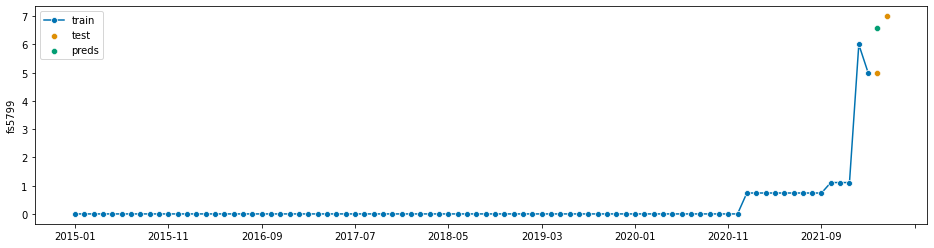

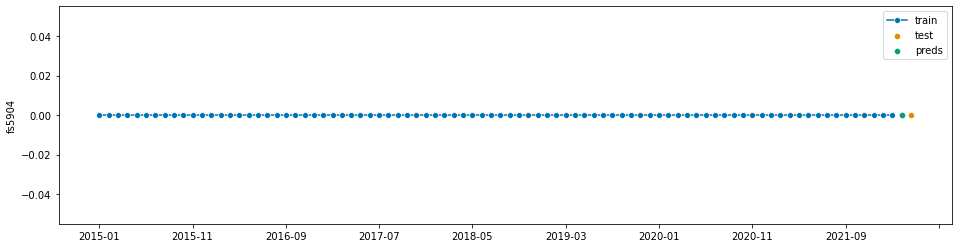

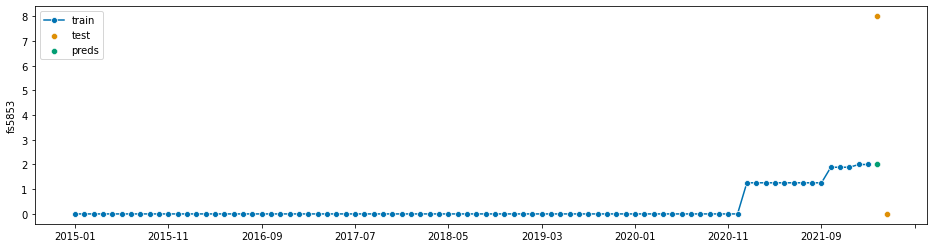

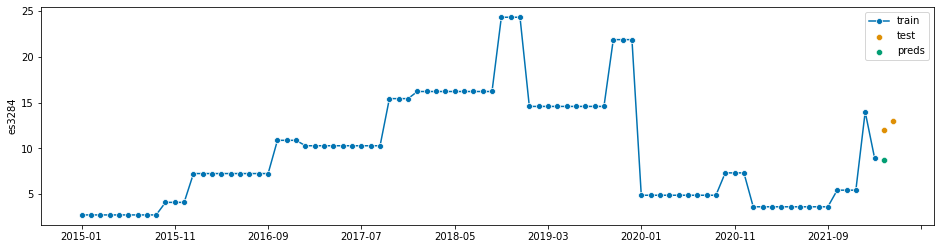

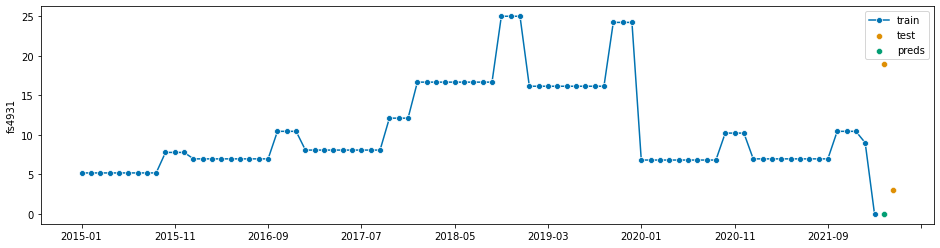

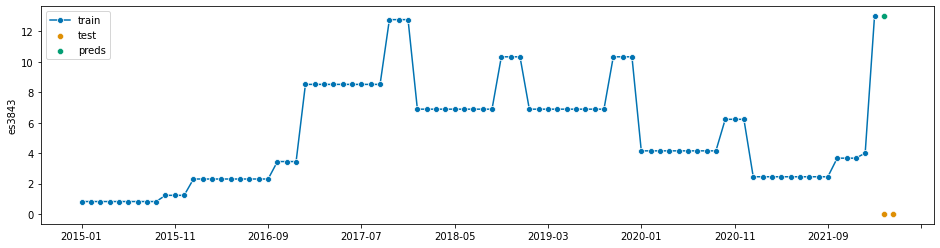

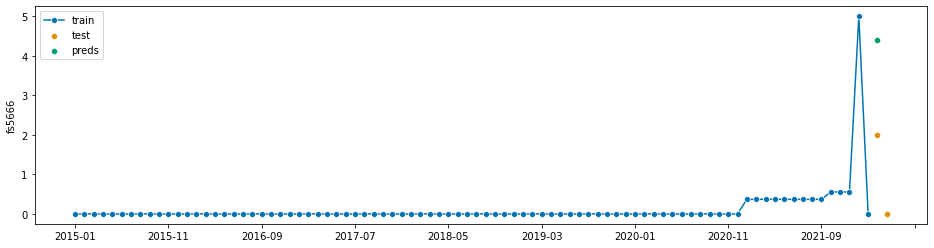

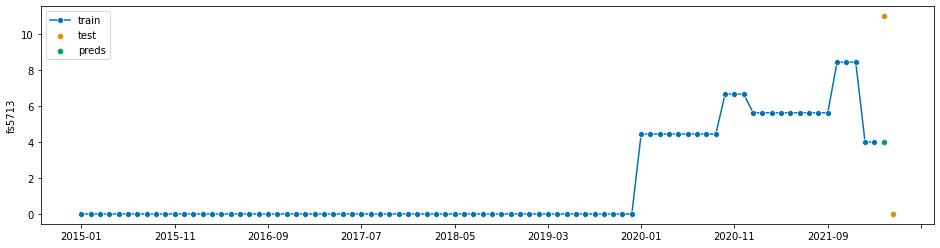

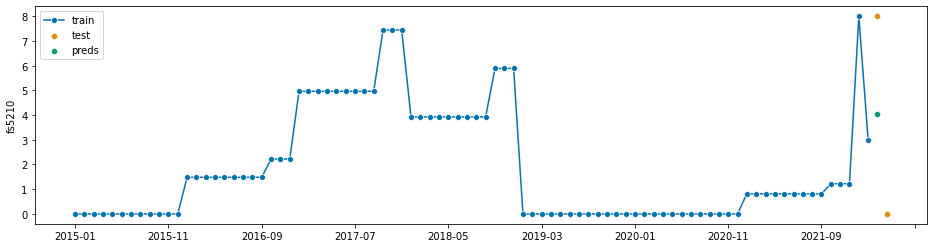

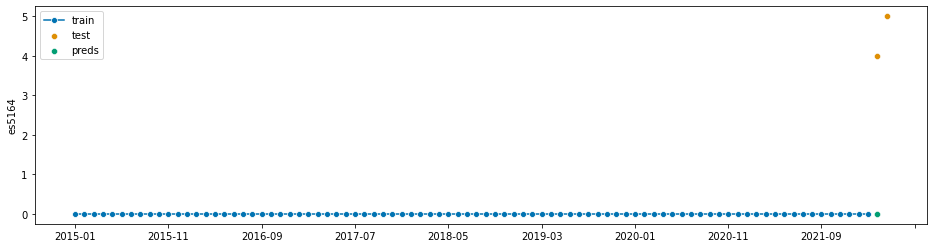

In [54]:
plot_pred(sarima_y_train, sarima_y_test, sarima_preds)

In [55]:
sarima_preds.T.sort_values(by = '2022-03',ascending=False)

,2022-03
fs5707,31.860742
fs4656,31.000000
es3282,26.935070
fs5877,17.640222
es3433,17.000000
...,...
fs5916,0.000000
fs5920,0.000000
fs5921,0.000000
fs5922,0.000000


## Discussion

Among these models, it seems that the baseline naive forecasting technique of using the rolling 6 month average is the method that minimizes the root mean squared error. This also happens to be the method that XYZ uses in forecasting. Given this information, I will use the rolling 6-month average as the forecasting method for models that have non-zero sales in the past 6 months. I will decrease the window size if sales have not begun until sometime in that period.

## Forecasting Function

In [56]:
def forecast(y):
    """ This function generates the next month's predictions for a dataframe containing monthly sales.
    Method: uses a naive forecasting method using the average of the last 6 months of sales. If sales 
    had not begun until months 1-5 prior, it will only uses the non-zero values.
    
    args:
        y (Pandas DataFrame): a dataframe containing past sales of products, where the columns
        are the product names, and the rows are monthly sales in datetime format withly monthly frequency.
    
    returns:
        preds (Pandas DataFrame): a dataframe containing predictions for the next month for each model
    """
    # Create a copy of y with nan to fill with predictions 
    preds = pd.DataFrame(data = y.iloc[[-1],:], columns = y.columns)
    preds.index = preds.index + 1
    preds.iloc[0,:] = np.nan

    rest = y.copy()
    x = -7
    window_length = 6
    while window_length > 0 :
        # assemble a list of models which had sales in the month (starting at 6 months prior and increasing to 2 months prior)
        collection = rest.iloc[x,:][rest.iloc[x,:] > 0].index
        if len(collection) > 0:
            model = NaiveForecaster(strategy='mean',window_length = window_length)
            model.fit(rest[collection])
            model_preds = model.predict(fh=1)
            model_preds.columns = collection
            # fill the pred with the prediction
            for model in collection:
                preds[model] = model_preds[model].values[0]
            rest = rest.drop(columns=collection)
        x += 1
        window_length -= 1
    # Fill the models which had no sales in this period with 0.
    preds.fillna(0,inplace=True)

    return preds
    

In [57]:
baseline_rolling_preds = forecast(y_train)

In [58]:
pred_rmse(y_test, baseline_rolling_preds)

6.205295608792355

In [59]:
r2_score(y_test.iloc[0,:], baseline_rolling_preds.T)

0.2448554639387278

In [60]:
r2_score(y_test.iloc[0,:], baseline_last_preds.iloc[0,:])

-0.1486268359447218

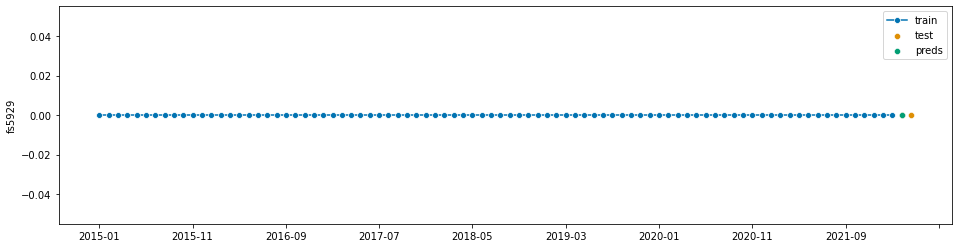

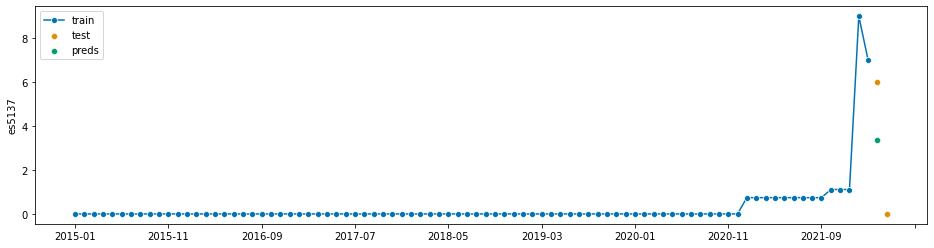

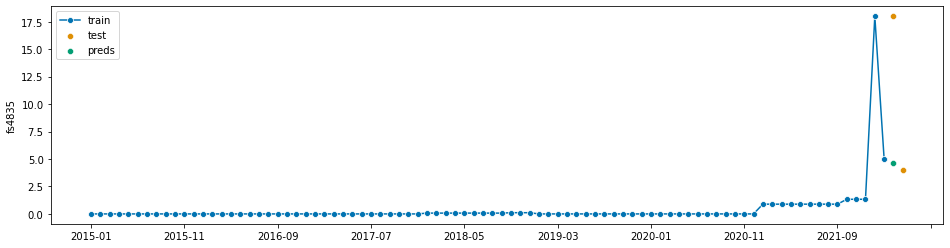

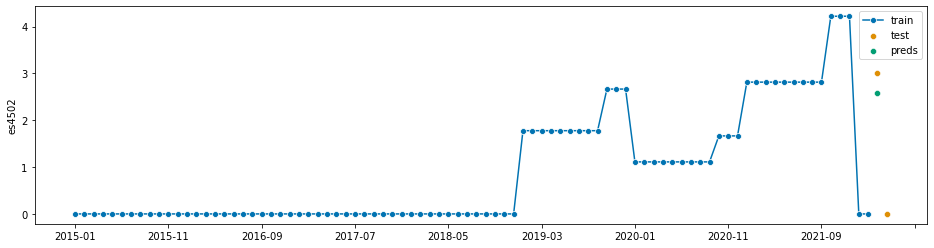

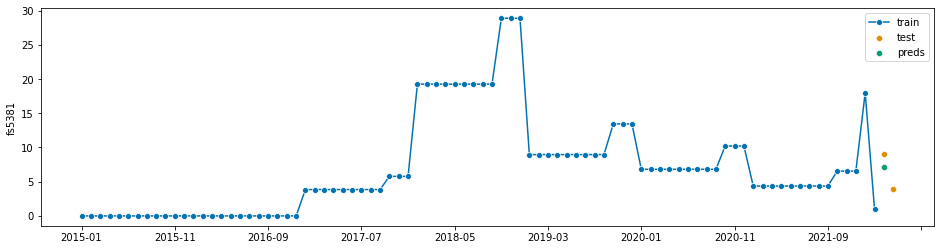

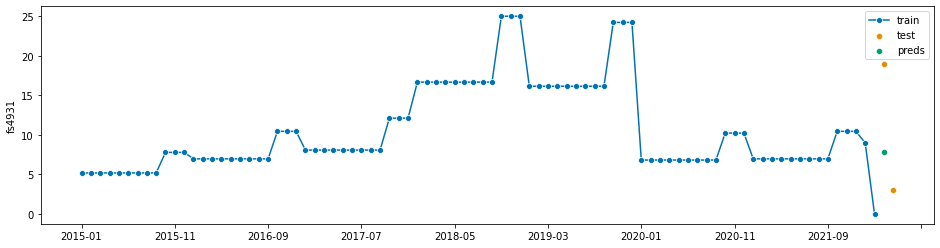

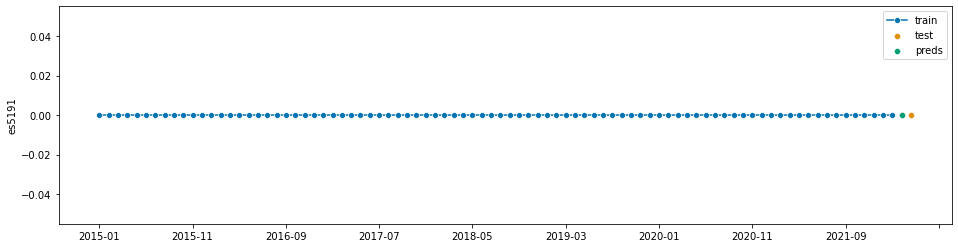

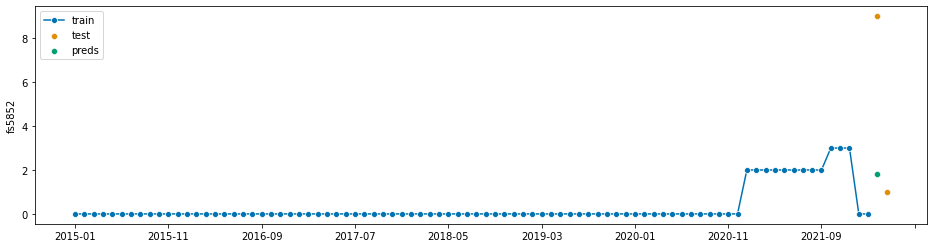

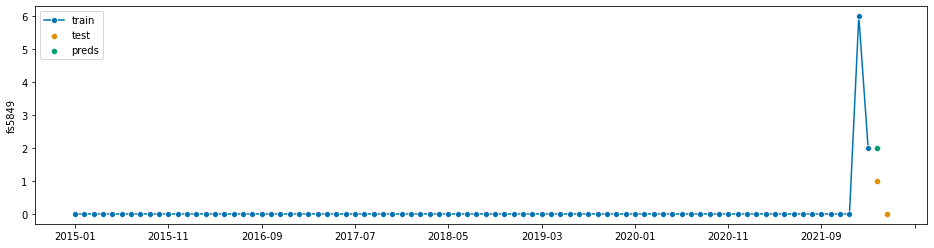

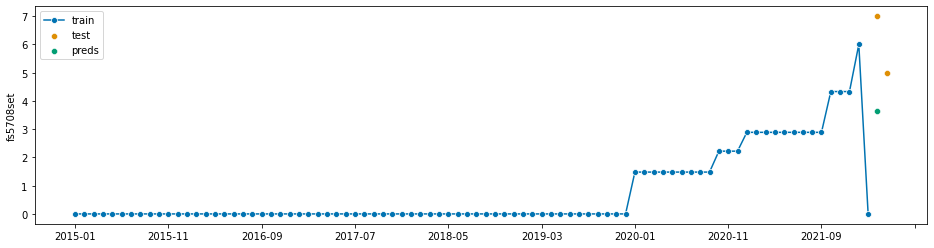

In [61]:
plot_pred(y_train, y_test, baseline_rolling_preds)

## Generate forecasts for proposal

In [62]:
monthly_forecast_Q3 = forecast(y)

In [63]:
monthly_forecast_Q3.index = ['monthly_forecast_Q3']

In [66]:
monthly_forecast_Q3.T.to_csv('../data/predictions/proposal_forecast.csv')